**By H.C. (Bram) Otten, s2330326**

The purpose of this exercise is to compare the Naive Bayes (NB) model to logistic regression (LR) on data with categorical attributes. We will first train/fit an NB and an LR model on some data set and then compare their performance by looking how well they predict in terms of 0/1-loss (misclassification rate, error percentage). We will do this on a real-world data set, the car evaluation data. [The dataset is in the UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation).

We learn on a training set that makes up 50% of our data. The assignment prescribes choices such as this, like some upcoming parameter choices, versions, and so on.

# Data

Idea: is a car suitable for purchase given a few characteristics (attributes)? We have 1728 samples and no missing values.

Outcome values [old, original values]: Negative [unacc], Positive [acc, good, vgood].

Attributes: 

- buying: vhigh, high, med, low.
- maint: vhigh, high, med, low.
- doors: 2, 3, 4, 5more.
- persons: 2, 4, more.
- lug_boot: small, med, big.
- safety: low, med, high.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from joblib import Parallel, delayed

In [2]:
car_data = []
for line in open("./car.data", "r"):
    row = line.strip().split(",")
    if row[6] == "unacc": row[6] = "Negative"
    else:
        row[6] = "Positive"
    car_data.append(row)

cd = pd.DataFrame(car_data)
cd.columns = [
    "buying", "maint", "doors", "persons", "lug_boot", "safety", "outcome"
]
cd = cd.astype("category")
cd.head(5)

,buying,maint,doors,persons,lug_boot,safety,outcome
0,vhigh,vhigh,2,2,small,low,Negative
1,vhigh,vhigh,2,2,small,med,Negative
2,vhigh,vhigh,2,2,small,high,Negative
3,vhigh,vhigh,2,2,med,low,Negative
4,vhigh,vhigh,2,2,med,med,Negative


# Methods

## Data preparation

In [3]:
min_n = 4  # need both 0 and 1 in y_train[:min_n]

In [4]:
def new_split(data):
    while True:
        train, test = train_test_split(data, test_size=0.5)
        X_train = pd.get_dummies(train.drop("outcome", axis=1))
        y_train = pd.get_dummies(train["outcome"])["Positive"]
        X_test = pd.get_dummies(test.drop("outcome", axis=1))
        y_test = pd.get_dummies(test["outcome"])["Positive"]
        if len(y_train[:min_n].unique()) == 2:
            break
    return X_train, y_train, X_test, y_test

In [5]:
# Store one reference split
np.random.seed(0)
X_train0, y_train0, X_test0, y_test0 = new_split(cd)
N = len(X_train0)
print(y_train0[:10])
X_train0.head(5)

1592    1
81      0
1698    0
1067    1
564     0
1095    0
44      0
1262    1
615     0
935     1
Name: Positive, dtype: uint8


,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
1592,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,1,0,0
81,0,0,0,1,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,1,0
1698,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
1067,0,0,1,0,1,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
564,1,0,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,1,0


## Naive Bayes (set-up of 1 and 2)

For each feature $X_j$ and outcome $y$,

$$P(X_j = k | y) = \frac{n_{k,y}+\alpha}{n_y + \alpha K_j},$$

where $n_{k, y}$ is the number of occurences of feature $k$ _and_ class $y$, $n_y$ is the number of occurences of class $y$, and $K_j$ is the number of values $X_j$ can take. $\alpha$ is our smoothing factor for preventing zero probabilities -- it is a parameter to be manually specified. 

Details on the used MultinomialNB function can be found [here](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) (note they use slightly different variable letters).

In [6]:
def nb_loss(X_train, y_train, X_test, y_test, alpha, n=N):
    nb_model = MultinomialNB(alpha=alpha).fit(
        X_train.iloc[:n, ], y_train.iloc[:n, ])
    return 1 - nb_model.score(X_test, y_test)

## Logistic regression (set-up of 3 and 4)

Details of the used LogisticRegression function can be found [here](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).

In [7]:
# Figure out which columns are for "buying" or "maint" (first two atts)
print(X_train0.columns)
print(X_train0.iloc[:, :8].columns)


def lr_loss(X_train, y_train, X_test, y_test, n=N, ta=False, l2=False):
    m = 8 if ta else len(X_train.columns)
    penalty = "l2" if l2 else "none"
    lr_model = LogisticRegression(penalty=penalty,
                                  solver="newton-cg").fit(X_train.iloc[:n, :m],
                                                          y_train.iloc[:n, ])
    return 1 - lr_model.score(X_test.iloc[:, :m], y_test)

Index(['buying_high', 'buying_low', 'buying_med', 'buying_vhigh', 'maint_high',
       'maint_low', 'maint_med', 'maint_vhigh', 'doors_2', 'doors_3',
       'doors_4', 'doors_5more', 'persons_2', 'persons_4', 'persons_more',
       'lug_boot_big', 'lug_boot_med', 'lug_boot_small', 'safety_high',
       'safety_low', 'safety_med'],
      dtype='object')
Index(['buying_high', 'buying_low', 'buying_med', 'buying_vhigh', 'maint_high',
       'maint_low', 'maint_med', 'maint_vhigh'],
      dtype='object')


# Comparison

## Average test error over multiple splits (end of 1 through 4)

In [8]:
def all_n_all_models(start=min_n):
    X_train, y_train, X_test, y_test = new_split(cd)
    return [[nb_loss(X_train, y_train, X_test, y_test, 1, n)
             for n in range(start, N)],
            [nb_loss(X_train, y_train, X_test, y_test, 0.1, n)
             for n in range(start, N)],
            [nb_loss(X_train, y_train, X_test, y_test, 10, n)
             for n in range(start, N)],
            [lr_loss(X_train, y_train, X_test, y_test, n)
             for n in range(start, N)],
            [lr_loss(X_train, y_train, X_test, y_test, n, ta=True)
             for n in range(start, N)],
            [lr_loss(X_train, y_train, X_test, y_test, n, l2=True)
             for n in range(start, N)]]


names = ["Naive Bayes with α = 1",
         "Naive Bayes with α = .1",
         "Naive Bayes with α = 10",
         "Logistic regression on all attributes",
         "Log. reg. on only 'buying' and 'maint'",
         "Log. reg. on all attr. with L2 penalty"]
M = 16

In [ ]:
if input("Respond 'y' if you're sure:") == "y":
    losses = Parallel(n_jobs=8)(delayed(all_n_all_models)() for _ in range(M))
    losses_np = np.array(losses)
    np.save("M{}losses".format(M), losses_np)

In [9]:
losses_np = np.load("M{}losses.npy".format(M))
ml = np.mean(losses_np, axis=0)

## 0/1 error as function of $n$ (5)

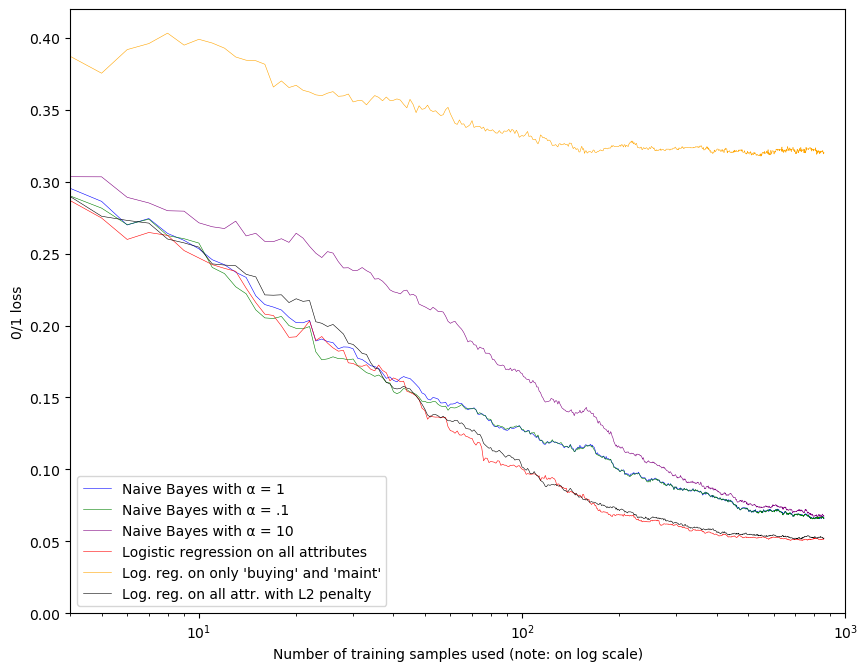


Average loss on 16 test sets for [n-2, n-1, n]:
[0.06568287 0.06647859 0.06561053] Naive Bayes with alpha = 1
[0.06561053 0.06647859 0.06597222] Naive Bayes with alpha = .1
[0.06734664 0.06792535 0.06741898] Naive Bayes with alpha = 10
[0.05128762 0.05164931 0.05164931] Logistic regression on all attributes
[0.31937211 0.31937211 0.32045718] Log. reg. on only 'buying' and 'maint'
[0.05179398 0.05215567 0.05215567] Log. reg. on all attr. with L2 penalty


In [10]:
fig = plt.figure(figsize=(10, 8), dpi=100)
plt.plot(ml[0], linewidth=0.4, label=names[0], color="blue")
plt.plot(ml[1], linewidth=0.4, label=names[1], color="green")
plt.plot(ml[2], linewidth=0.4, label=names[2], color="purple")
plt.plot(ml[3], linewidth=0.4, label=names[3], color="red")
plt.plot(ml[4], linewidth=0.4, label=names[4], color="orange")
plt.plot(ml[5], linewidth=0.4, label=names[5], color="black")
plt.xscale("log")
plt.xlim(min_n, 1000)
plt.ylim(0, 0.42)
plt.xlabel("Number of training samples used (note: on log scale)")
plt.ylabel("0/1 loss")
plt.legend()
plt.show()

print("\nAverage loss on {} test sets for [n-2, n-1, n]:".format(M))
for i in range(6):
    print(ml[i, -3:], names[i].replace('α', 'alpha'))

Let us analyse the plot of these 0/1-errors as function of $n = 1, \ldots, N$ training samples for all models. First of all, regressing on fewer training samples generally results in a greater loss (or, equivalently, a lower score). Only a little more suprising is that the logistic regression on only the first two attributes results in a lower score -- it implies the other attributes contain information that is useful for predicting outcome. We can also conclude that different parameter values for the (full) models leads to convergence to almost the same score (at least with the chosen $\alpha$s for NB and the (lack of an) L2 penalty for LR). 

The plots for NB with $\alpha = 1$ and $\alpha = .1$ are hard to distinguish for not-tiny $n$; the (difference in) $\alpha$ is then small in proportion to the other quantities that determine the model fit. This proportion is rather large even for much higher $n$ with $\alpha = 10$, which explains the difference in graph. An $\alpha$ closer to 0 is not necessarily better for predicting unseen data, but the resulting predictions will reflect proportions in the training data more closely. (Higher $\alpha$ can result in lower variance / more bias.)

Adding the L2 penalty to the LR model is supposed to reduce overfitting, and is thus expected to result in lower loss especially with low $n$. (Fits made to a smaller sample are less likely to be 'true' in general, i.e. for unseen data.) (The penalty is also supposed to handle collinearity if we care about interpretability.) This expectation is not met -- the penalized and unpenalized models do not obtain very different test scores for any $n$.

## The winning method (6)

It looks like logistic regression (without penalty) on all attributes performs best: its loss is almost always lower than all alternative models. This is average loss over multiple random splits with a relatively large amount of testing data (50%), so we can be fairly sure that real-world 'performance' will be good as well. 

Having said that, the difference in loss between the NB and full LR models is quite small (i.e. around 0.015) -- the NB models are also expected to do well.

## Results vs theory (7)

Look to question 5 above for an 'analysis' of what influence parameter values have on the models and how this relates to expectations based on theory. 

The difference between the best-performing versions of the NB and LR algorithms has not been covered above. The best versions are $\alpha = 1$ and all attributes without L2 penalty respectively. 

We would expect NB to result in a lower loss than LR for small $n$ and in higher loss for large $n$. (Quote from the abstract of [the Ng & Jordan paper](https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf): "while discriminative learning [LR] has lower asymptotic error, a generative classifier [NB] may also approach its (higher) asymptotic error much faster.") We confirm that LR outperforms NB eventually, but not that NB does better with smaller $n$. 

This is a reoccuring pattern in talking about our results and expectations: the models that are expected to be better only with large $n$ actually work well with small $n$ too. 

## Method desirability (8)

We prefer LR since we have a large enough amount of data for it to outperform NB (not only experimentally, but also based on theory: we have $n > O$(number of $X_j$s)).

We prefer LR since we are only doing binary classification and do not care about exact probabilities of how likely some class is give [...].

We prefer the penalized version of LR since it will be a little less likely to fit only the training data. This 'insight' is not confirmed in our experiments however, and this whole practice is less important than it was in the last assignment since we do not try to interpret the influence the possibly collinear attributes have on our predictions -- but including penalization does not make the model (much) worse even here.

Using fewer regressors might generally be desirable, but the data for the attributes that are left out in the case of using only 'buying' and 'maint' seems relatively easy to find and is apparently useful. So, in this case we prefer to _not_ leave these other attributes out.

## Estimated probabilities (9)

We will fit best-performing models to the same training set.

NB on training set: 0.04166666666666663
LR ,,             : 0.03125


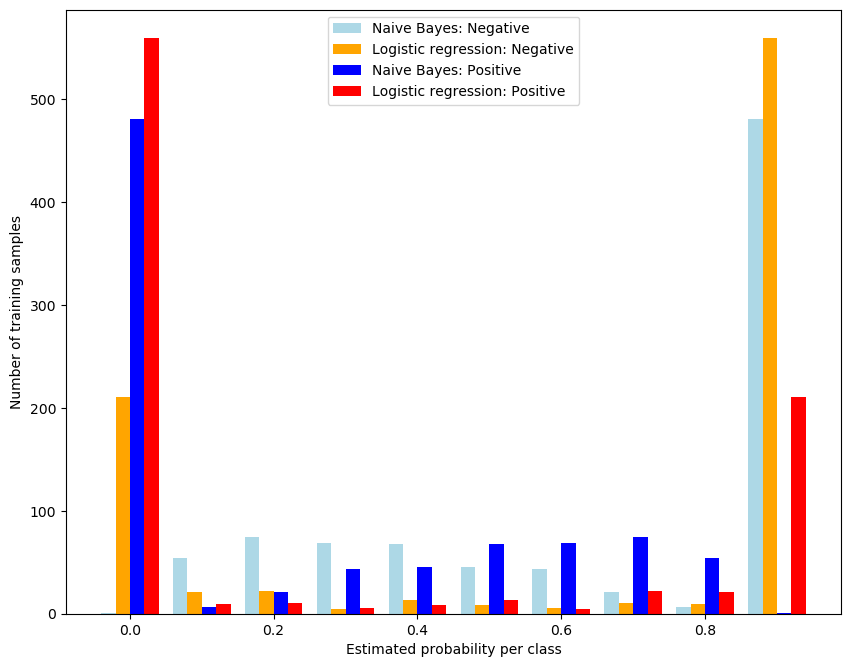

In [11]:
nb_model = MultinomialNB(alpha=1).fit(X_train0, y_train0)
nb_preds = nb_model.predict_proba(X_train0)
lr_model = LogisticRegression(penalty="none", solver="newton-cg").fit(
    X_train0, y_train0
)
lr_preds = lr_model.predict_proba(X_train0)

print("NB on training set: {}".format(1 - nb_model.score(X_train0, y_train0)))
print("LR ,,             : {}".format(1 - lr_model.score(X_train0, y_train0)))

fig = plt.figure(figsize=(10, 8), dpi=100)
plt.hist(
    [nb_preds[:, 0], lr_preds[:, 0], nb_preds[:, 1], lr_preds[:, 1]],
    label=["Naive Bayes: Negative", "Logistic regression: Negative",
           "Naive Bayes: Positive", "Logistic regression: Positive", ],
    color=["lightblue", "orange", "blue", "red"],
    bins=10,
    align="left",
)
plt.xlabel("Estimated probability per class")
plt.ylabel("Number of training samples")
plt.legend()
plt.show()

Both models predict the training data very well. The models predict whichever of the two outcomes it considers most likely (of course, both probabilities sum to 1 per instance). The LR model generally ascribes either a very high (>.95) or very low (< .05) probability to outcomes, while NB's probabilities have less of an inverted-U distribution. 

This _is_ in accordance with theory. The generative NB estimates $P(X, y)$ whereas the discriminative LR estimates $P(y | X)$.  

This characteristic in itself does not tell us much about how well the models can fit the training data. But as mentioned above: we only care about discrimination / classification -- LR is good enough for that and obtains lower test error.

## Bonus

See above.